Epoch 0: Accuracy 0.000, Average Loss 2.3016059160232545
Epoch 0: Accuracy 0.000, Average Loss 2.3012566804885863

Epoch 1: Accuracy 0.000, Average Loss 2.265299234390259
Epoch 1: Accuracy 0.000, Average Loss 2.2625476837158205

Epoch 2: Accuracy 0.002, Average Loss 2.070562515258789
Epoch 2: Accuracy 0.001, Average Loss 2.053320360183716

Epoch 3: Accuracy 0.045, Average Loss 1.960132212638855
Epoch 3: Accuracy 0.057, Average Loss 1.9261577606201172

Epoch 4: Accuracy 0.110, Average Loss 1.816424117088318
Epoch 4: Accuracy 0.130, Average Loss 1.7413316726684571

Epoch 5: Accuracy 0.131, Average Loss 1.6798151516914368
Epoch 5: Accuracy 0.162, Average Loss 1.6027872681617736

Epoch 6: Accuracy 0.131, Average Loss 1.5585512685775758
Epoch 6: Accuracy 0.165, Average Loss 1.4686487793922425

Epoch 7: Accuracy 0.199, Average Loss 1.4950653362274169
Epoch 7: Accuracy 0.244, Average Loss 1.4064989686012268

Epoch 8: Accuracy 0.253, Average Loss 1.4284691858291625
Epoch 8: Accuracy 0.298, Ave

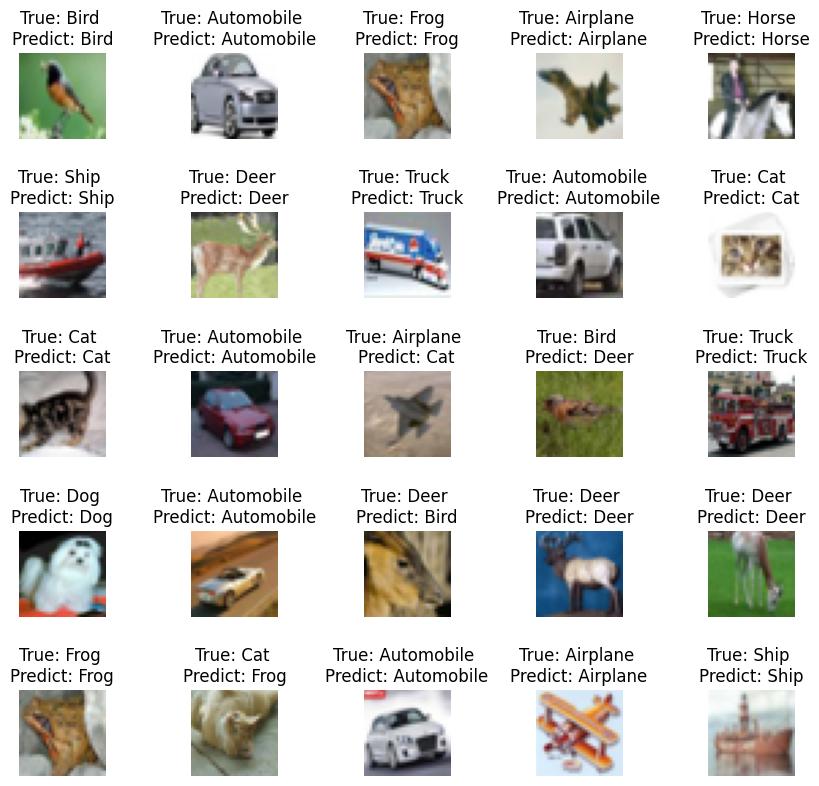

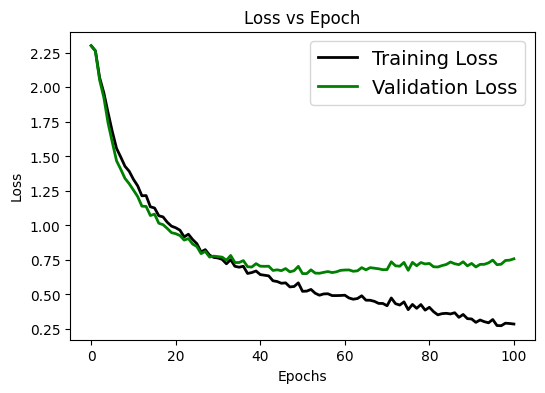

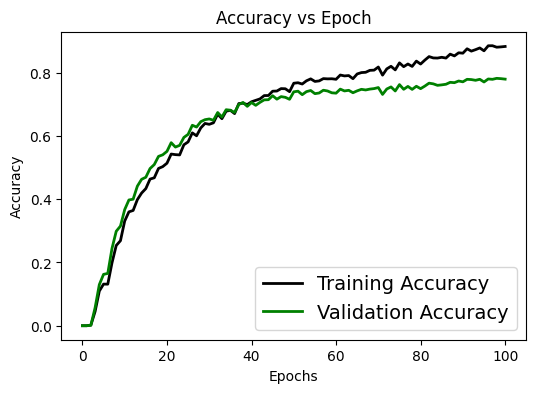

In [1]:
# train the model

import os
import sys

import numpy as np
import mlx.core as mx
import mlx.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

from softgrad import Network
from softgrad.layer.transform import Flatten, Reshape, Transpose
from softgrad.layer.shim import MLX
from softgrad.optim import SGD
from softgrad.function.activation import leaky_relu, softmax, relu
from softgrad.function.loss import CrossEntropyLoss, cross_entropy_loss
from softgrad.layer.core import Linear, Activation

sys.path.append(os.path.abspath('..'))
from util.dataset import get_mnist, get_fashion_mnist, get_cifar10


# Visualize
def viz_sample_predictions(network, test_data, label_map, rows=5, cols=5, figsize=(10, 10)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize, num="Sample Predictions")
    axes = axes.reshape(-1)  # flatten

    test_data = test_data.to_buffer().shuffle()
    def sample_random():
        for j in np.arange(0, rows * cols):
            i = np.random.randint(0, len(test_data))
            x = mx.array(test_data[i]['image'])
            y = mx.array(test_data[i]['label'])
            y_pred = network.forward(x[mx.newaxis, ...])

            sample = np.array(255 * x)
            if sample.shape[2] == 3:
                image = Image.fromarray(sample.astype('uint8'))
            else:
                image = Image.fromarray(sample.reshape(sample.shape[0], sample.shape[1]))

            raw_label = mx.argmax(y).item()
            label = label_map[raw_label]

            raw_pred = mx.argmax(y_pred).item()
            pred = label_map[raw_pred]

            axes[j].imshow(image)
            axes[j].set_title(f"True: {label} \nPredict: {pred}")
            axes[j].axis('off')
            plt.subplots_adjust(wspace=1)

    def on_key(event):
        if event.key == ' ':
            sample_random()
            fig.show()

    fig.canvas.mpl_connect('key_press_event', on_key)

    sample_random()


def viz_history(history, figsize=(6, 4)):
    plt.figure(figsize=figsize, num="Loss Curves")
    plt.plot(history['epoch'], history['train_loss'], 'black', linewidth=2.0)
    plt.plot(history['epoch'], history['test_loss'], 'green', linewidth=2.0)
    plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
    plt.xlabel('Epochs', fontsize=10)
    plt.ylabel('Loss', fontsize=10)
    plt.title('Loss vs Epoch', fontsize=12)

    plt.figure(figsize=figsize, num="Accuracy Curves")
    plt.plot(history['epoch'], history['train_accuracy'], 'black', linewidth=2.0)
    plt.plot(history['epoch'], history['test_accuracy'], 'green', linewidth=2.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
    plt.xlabel('Epochs', fontsize=10)
    plt.ylabel('Accuracy', fontsize=10)
    plt.title('Accuracy vs Epoch', fontsize=12)


# Evaluate
def eval_model(model, dataset, epoch=None):
    mean_losses = []
    accuracies = []
    predictions = []

    for batch in dataset:
        x_batch = mx.array(batch["image"])
        y_batch = mx.array(batch["label"])

        y_pred = model.forward(x_batch)
        predictions.append(y_pred)

        loss = optimizer.loss_fn(y_pred, y_batch)
        mean_loss = mx.mean(mx.sum(loss, axis=1))
        mean_losses.append(mean_loss.item())

        if isinstance(optimizer.loss_fn, CrossEntropyLoss):
            y_pred = softmax(y_pred)

        errors = mx.sum(mx.abs(y_batch - mx.round(y_pred)), axis=1)
        accuracy = mx.sum(errors == 0) / y_batch.shape[0]
        accuracies.append(accuracy.item())

    mean_loss = sum(mean_losses) / len(mean_losses)
    accuracy = sum(accuracies) / len(accuracies)
    predictions = np.concatenate(predictions)

    dataset.reset()

    if epoch is not None:
        print(f"Epoch {epoch}: Accuracy {accuracy:.3f}, Average Loss {mean_loss}")
    else:
        print(f"Accuracy {accuracy:.3f}, Average Loss {mean_loss}")

    return predictions, accuracy, mean_loss


def train(train_data, epochs, batch_size=1, test_data=None, cb=None):
    batched_train_data = train_data.batch(batch_size)
    batched_test_data = test_data.batch(batch_size)

    def train_epoch():
        for batch in batched_train_data:
            x_batch = mx.array(batch["image"])
            y_batch = mx.array(batch["label"])
            optimizer.step(x_batch, y_batch)
        batched_train_data.reset()

    history = {"epoch": [], "train_loss": [], "test_loss": [], "train_accuracy": [], "test_accuracy": []}

    _, train_accuracy, train_loss = eval_model(network, batched_train_data, epoch=0)
    _, test_accuracy, test_loss = eval_model(network, batched_test_data, epoch=0)
    print()
    history["epoch"].append(0)
    history["train_loss"].append(train_loss)
    history["test_loss"].append(test_loss)
    history["train_accuracy"].append(train_accuracy)
    history["test_accuracy"].append(test_accuracy)

    for epoch in range(1, epochs + 1):
        train_epoch()

        _, train_accuracy, train_loss = eval_model(network, batched_train_data, epoch=epoch)
        _, test_accuracy, test_loss = eval_model(network, batched_test_data, epoch=epoch)
        print()
        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)
        history["train_accuracy"].append(train_accuracy)
        history["test_accuracy"].append(test_accuracy)

    test_data.reset()
    eval_model(network, batched_test_data)
    print()

    viz_sample_predictions(network, test_data, label_map)
    viz_history(history)
    plt.show()


# train_data, test_data = get_mnist(static=True)
# label_map = ["Zero", "One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Nine"]

# train_data, test_data = get_fashion_mnist(static=True)
# label_map = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

train_data, test_data = get_cifar10(static=False)
label_map = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

network = Network(input_shape=(32, 32, 3))

# conv block 1
network.add_layer(MLX(nn.Conv2d(in_channels=3, out_channels=96, kernel_size=7)))
network.add_layer(Activation(leaky_relu))
network.add_layer(MLX(nn.MaxPool2d(2)))
# conv block 2
network.add_layer(MLX(nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3)))
network.add_layer(Activation(leaky_relu))
network.add_layer(MLX(nn.MaxPool2d(2)))
# feed forward
network.add_layer(Flatten())
network.add_layer(Linear(1024))
network.add_layer(Activation(leaky_relu))
network.add_layer(Linear(10))

optimizer = SGD(eta=0.05, momentum=0.9, weight_decay=0.0005)
optimizer.bind_loss_fn(cross_entropy_loss)
optimizer.bind_network(network)

train(train_data, epochs=100, batch_size=1000, test_data=test_data)

Kernel Shape: (96, 7, 7, 3)
Example: [[[ 0.09442439  0.08634232  0.02032739]
  [-0.04547756 -0.02727387 -0.10586637]
  [ 0.01427214 -0.00843127  0.01024943]
  [ 0.0470538   0.11432322 -0.02014271]
  [ 0.05357853 -0.00349017 -0.13991481]
  [-0.08920068 -0.07799726 -0.132141  ]
  [-0.03704084  0.05392929 -0.12869728]]

 [[-0.0461412   0.10276733 -0.04737886]
  [ 0.08265781 -0.02653448 -0.02230156]
  [ 0.0312875   0.07255483 -0.09155463]
  [ 0.00377501  0.09182643  0.04170676]
  [-0.06913099 -0.0640109  -0.14155334]
  [-0.045102   -0.01405415 -0.00463016]
  [-0.09907702 -0.06686418 -0.02320468]]

 [[-0.08569589  0.07555795 -0.09738813]
  [-0.04873735  0.08093747 -0.07194562]
  [ 0.05847997  0.06292458 -0.07576594]
  [ 0.07683656  0.04580712 -0.1035568 ]
  [ 0.04675514 -0.0665684  -0.05058402]
  [ 0.00420229  0.07055103 -0.0798662 ]
  [-0.00326083 -0.07704392 -0.15582627]]

 [[-0.09932593 -0.01914595 -0.04563092]
  [ 0.0204398  -0.00623667 -0.03344787]
  [-0.00403818  0.02687495 -0.0821664

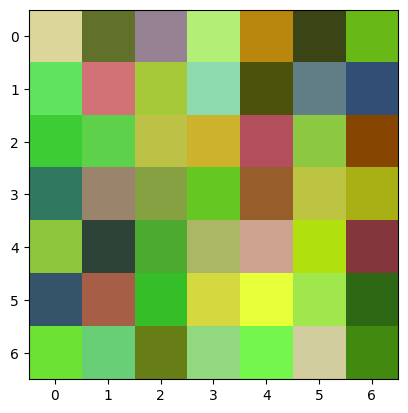

In [3]:
kernels = network.layers[0].params['weight']
kernel = np.array(kernels[50])
print("Kernel Shape:", kernels.shape)
print("Example:", kernel)

def normalize(kernel):
    kernel -= np.min(kernel)
    kernel /= np.max(kernel)
    return (255 * kernel).astype(np.uint8)

kernel_img = Image.fromarray(normalize(kernel))
plt.imshow(kernel_img)

Mins 0.0 0.0 0.0
Maxs 1.0 1.0 1.0


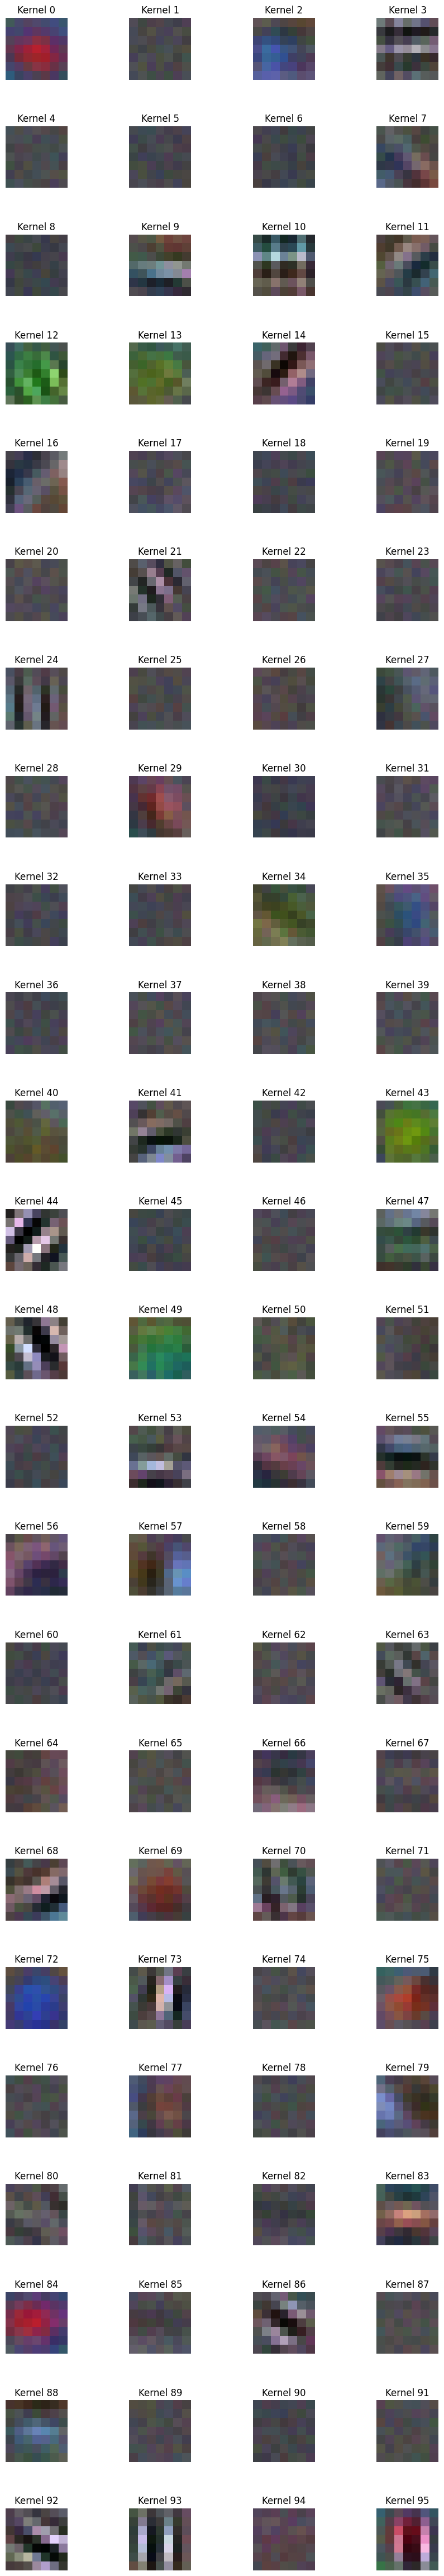

In [7]:
def viz_kernels(kernels, rows=24, cols=4, figsize=(10, 60)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize, num="Sample Predictions")
    axes = axes.reshape(-1)  # flatten

    def normalize_kernels(kernels):
        kernels = np.array(kernels)

        # kernels = 1 / (1 + np.exp(-2 * kernels))
        # kernels = kernels - np.min(kernels)
        # kernels = kernels / np.max(kernels)

        r_min, g_min, b_min = np.min(kernels[:, :, :, 0]), np.min(kernels[:, :, :, 1]), np.min(kernels[:, :, :, 2])
        kernels -= np.array([r_min, g_min, b_min])
        r_max, g_max, b_max = np.max(kernels[:, :, :, 0]), np.max(kernels[:, :, :, 1]), np.max(kernels[:, :, :, 2])
        kernels /= np.array([r_max, g_max, b_max])
        kernels = np.square(kernels)

        print("Mins", np.min(kernels[:, :, :, 0]), np.min(kernels[:, :, :, 1]), np.min(kernels[:, :, :, 2]))
        print("Maxs", np.max(kernels[:, :, :, 0]), np.max(kernels[:, :, :, 1]), np.max(kernels[:, :, :, 2]))

        return kernels

    kernels = normalize_kernels(kernels)

    def normalize(kernel):
        return (255 * kernel).astype(np.uint8)

    def imagize(kernel):
        return Image.fromarray(normalize(kernel))

    for j, kernel in enumerate(kernels):
        kernel_img = imagize(kernel)
        axes[j].imshow(kernel_img)
        axes[j].set_title(f"Kernel {j}")
        axes[j].axis('off')
        plt.subplots_adjust(wspace=1)

    plt.show()

viz_kernels(network.layers[0].params['weight'])